<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данном семинаре мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud). 


<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Решить проблему сильного дисбаланса классов. </li>
<li>Построить модели на основе классических алгоритмов машинного обучения. </li>
<li>Использовать нейросетевые подходы для решения данной задачи. </li>
<li> Провести сравнительный анализ классических подходов и нейросетевых. </li>

## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент). 

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"

import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

Подключимся к диску для загрузки данных.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загружаем данные.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Проверим на наличие пропусков в данных.

In [ ]:
# ВАШ КОД ЗДЕСЬ

0

Выведем названия столбцов.

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Еще раз оценим отношение классов целевой переменной.

In [ ]:
print('Обычные транзакции составляют', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% данных')
print('Мошеннические транзакции составляют', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% данных')

Обычные транзакции составляют 99.83 % данных
Мошеннические транзакции составляют 0.17 % данных


**Важно!** 

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках. 

Text(0.5, 1.0, 'Распределение классов \n (0: Не мошенник || 1: Мошенник)')

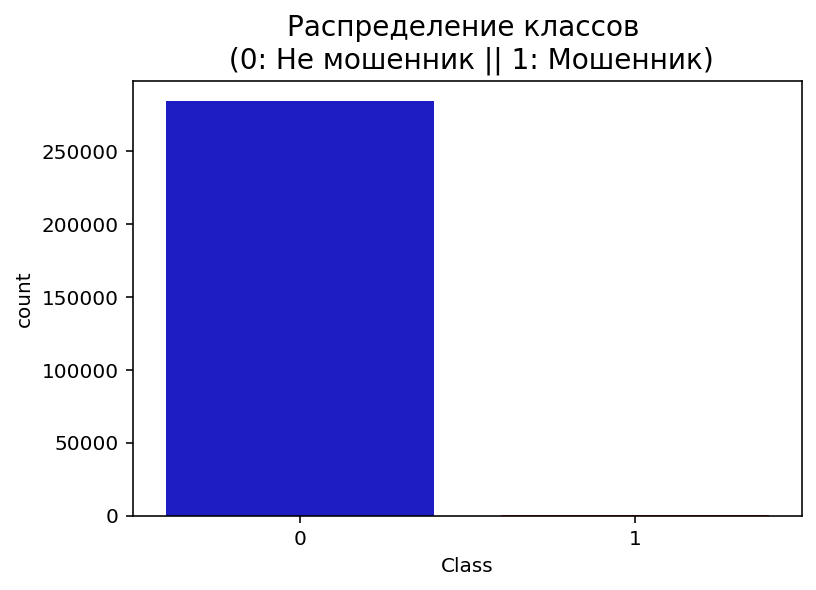

In [ ]:
colors = ["#0101DF", "#DF0101"]

# ВАШ КОД ЗДЕСЬ # строим гистограмму целевой переменной
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)

Построим распределения по суммам и времени транзакций.

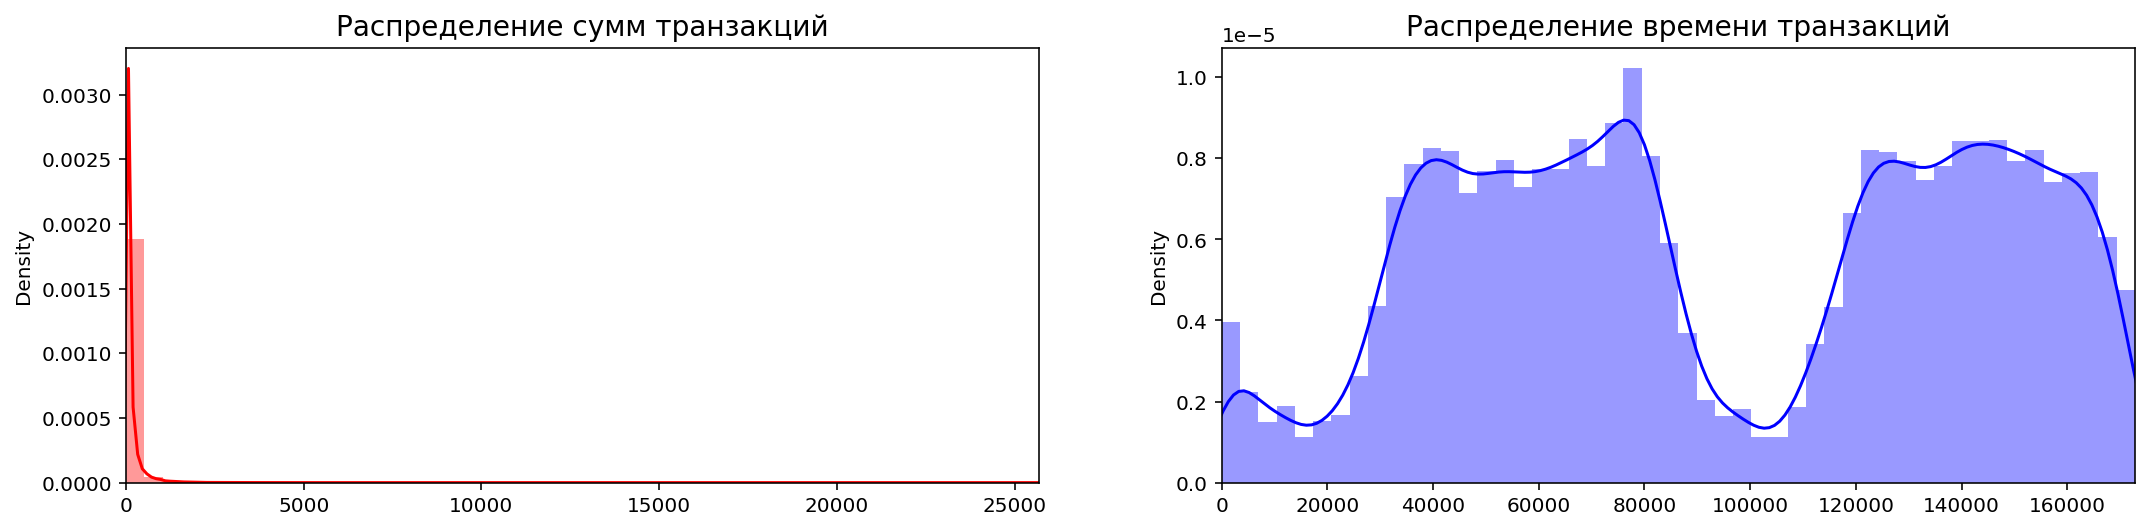

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

# ВАШ КОД ЗДЕСЬ # строим график распределения суммы транзакций
ax[0].set_title('Распределение сумм транзакций', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# ВАШ КОД ЗДЕСЬ # строим график распределения времени транзакций
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!** 

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем? 

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.

In [ ]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы, 
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = # ВАШ КОД ЗДЕСЬ

original_Xtrain['scaled_amount'] = # ВАШ КОД ЗДЕСЬ
original_Xtest['scaled_amount'] = # ВАШ КОД ЗДЕСЬ

original_Xtrain['scaled_time'] = # ВАШ КОД ЗДЕСЬ
original_Xtest['scaled_time'] = # ВАШ КОД ЗДЕСЬ

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!** 

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [ ]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными, 
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
158988,112060.0,-2.284095,0.950842,2.421164,0.165229,-1.558691,1.907963,-1.308283,0.951898,0.929724,...,-0.396303,0.340093,-0.371409,0.691552,0.592366,-0.290705,-0.135277,-0.374416,15.00,0
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
44541,41986.0,0.688092,-0.653793,1.325675,1.306273,-1.103125,0.464962,-0.617399,0.290125,0.261281,...,0.467151,0.994964,-0.201018,0.255761,0.180050,-0.261005,0.055650,0.066704,200.00,0
18466,29526.0,1.102804,2.829168,-3.932870,4.707691,2.937967,-1.800904,1.672734,-0.300240,-2.783011,...,-0.106994,-0.250050,-0.521627,-0.448950,1.291646,0.516327,0.009146,0.153318,0.68,1
93424,64412.0,-1.348042,2.522821,-0.782432,4.083047,-0.662280,-0.598776,-1.943552,-0.329579,-1.853274,...,1.079871,-0.352026,-0.218358,0.125866,-0.074180,0.179116,0.612580,0.234206,1.00,1


Распределение классов в подвыборке
0    0.5
1    0.5
Name: Class, dtype: float64


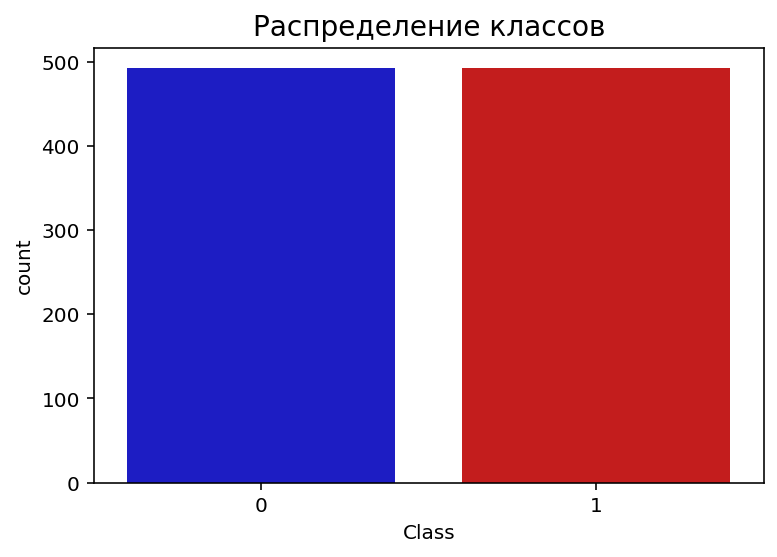

In [ ]:
print('Распределение классов в подвыборке')
print(new_df['Class'].value_counts()/len(new_df))

# ВАШ КОД ЗДЕСЬ # проверяем снова распределение целевой переменной
plt.title('Распределение классов', fontsize=14)
plt.show()

### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


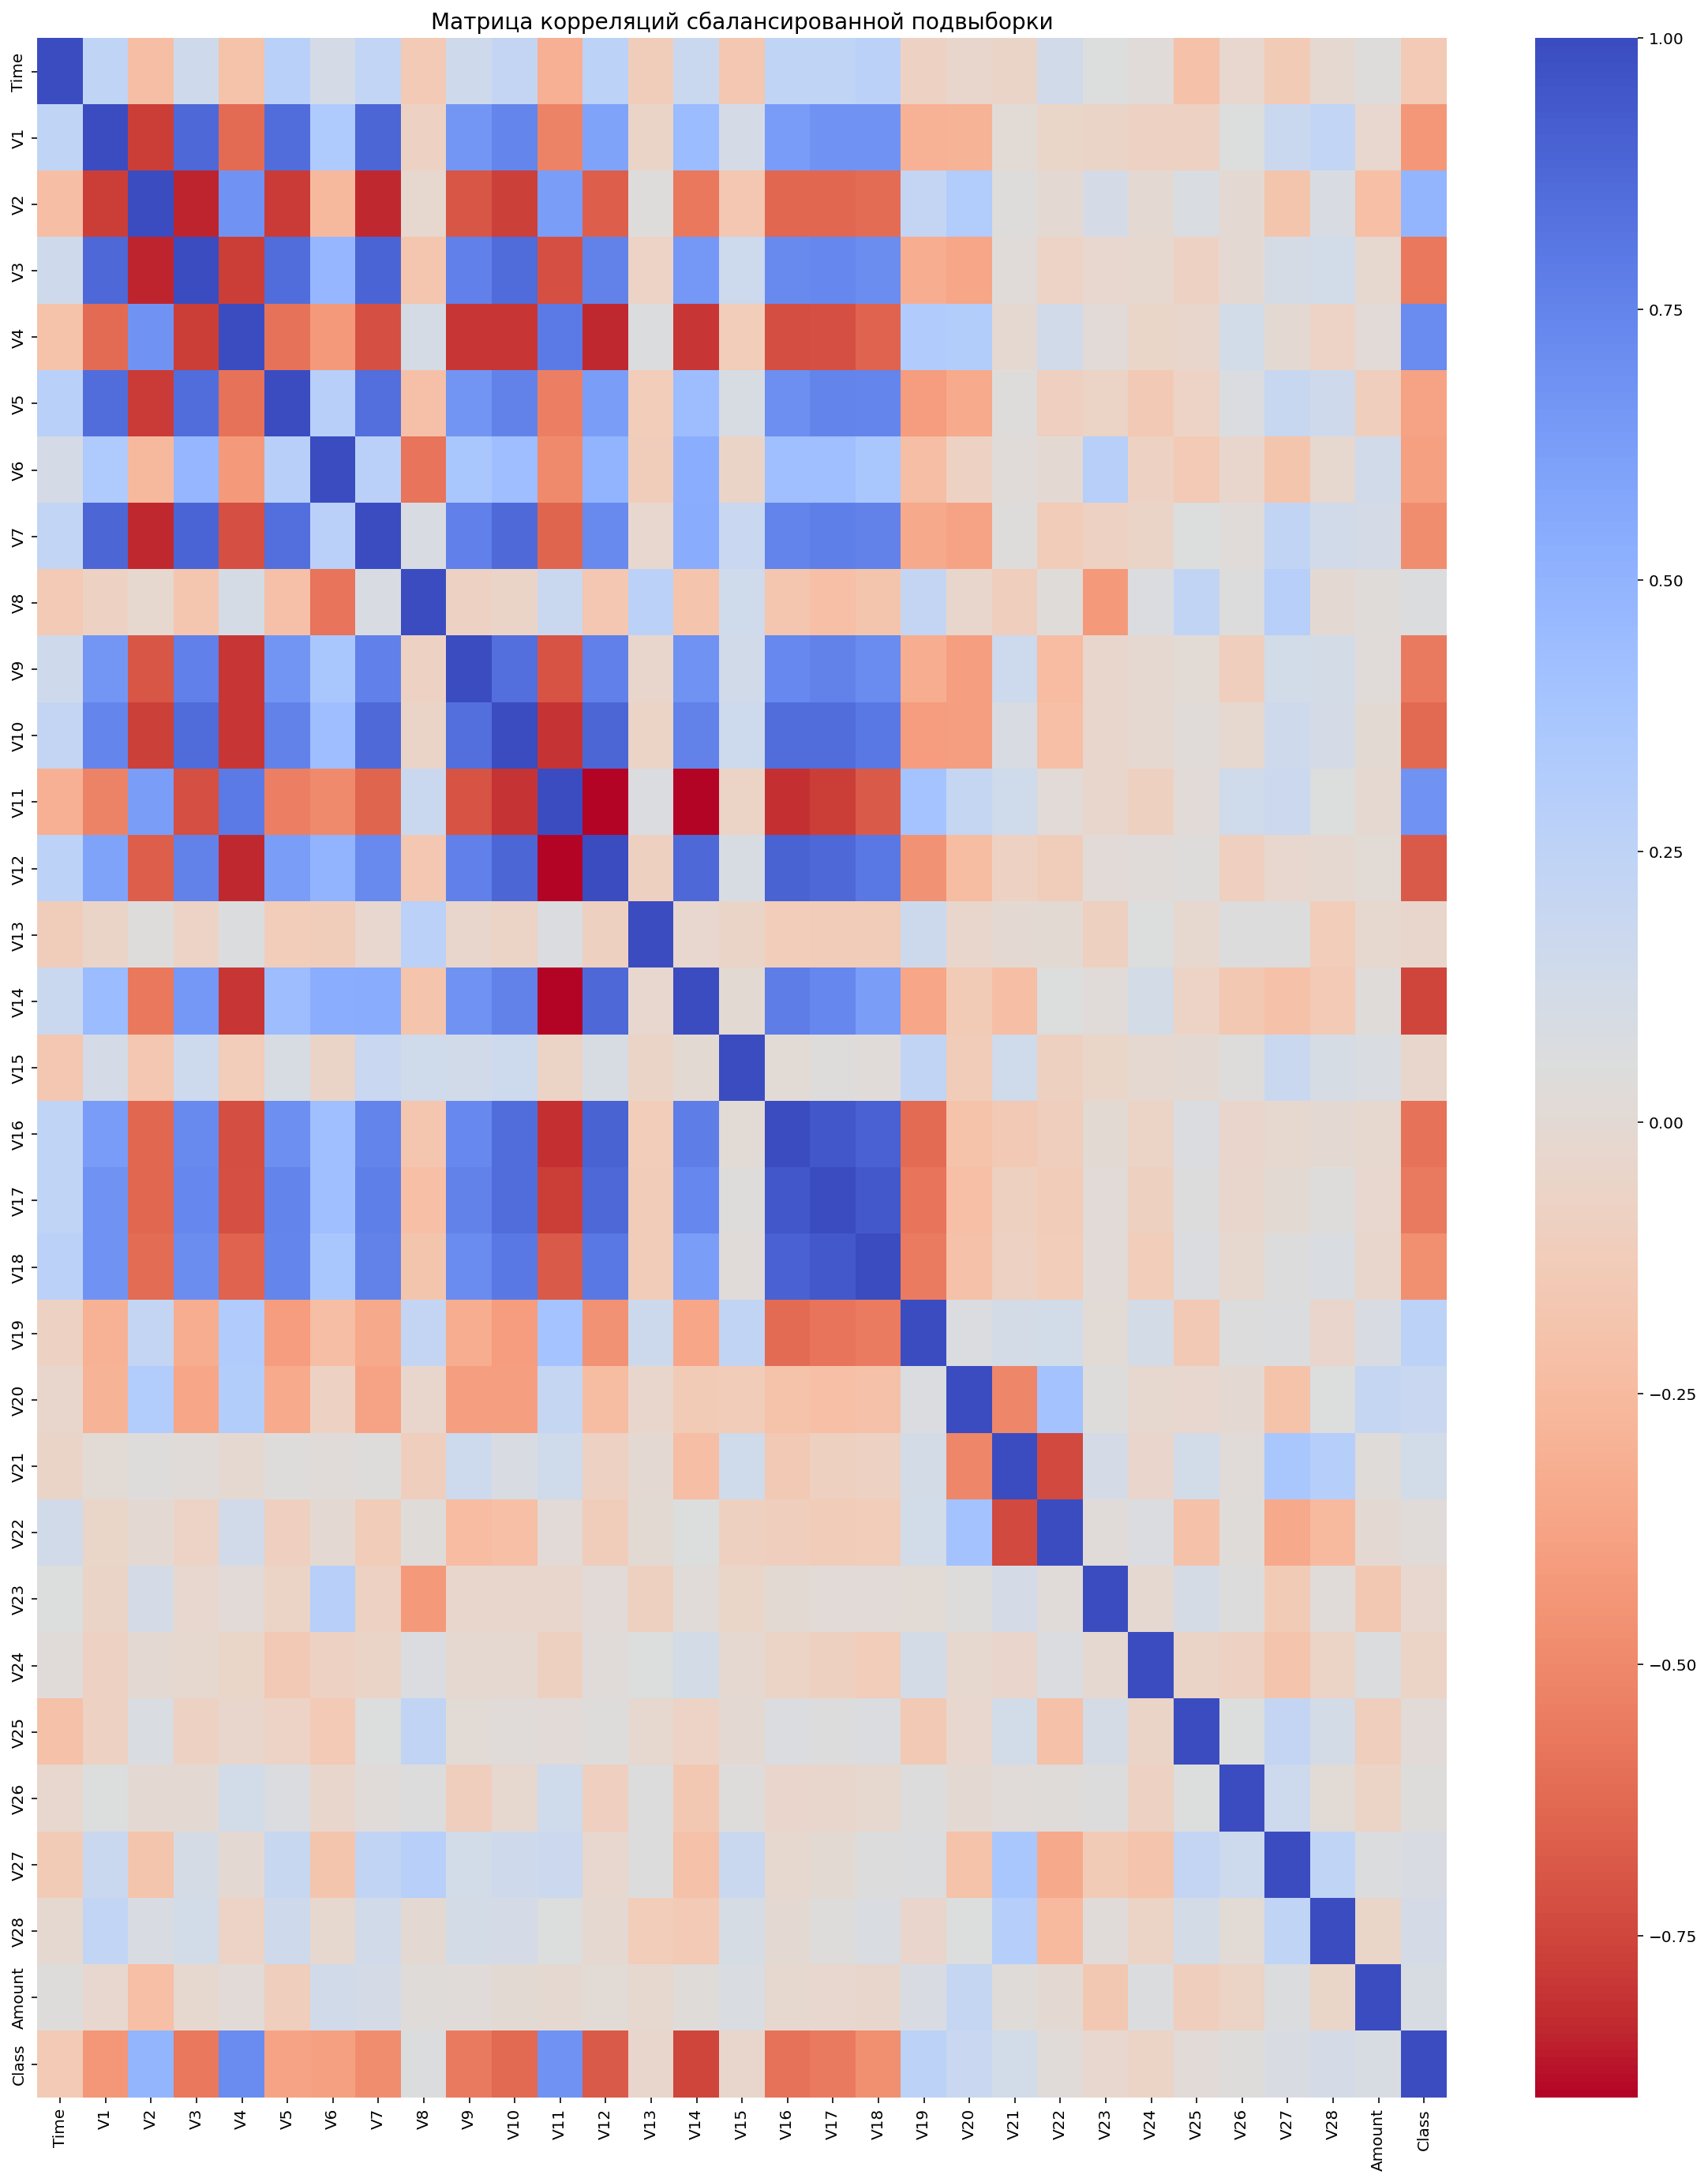

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций
# ВАШ КОД ЗДЕСЬ
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()

### Выводы: 
<ul>
<li><b>Отрицательные корреляции: </b>Признаки V17, V14, V12 и V10 имеют отрицательную корреляцию. Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Признаки V2, V4, V11 и V19 положительно коррелируют. То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!** 

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

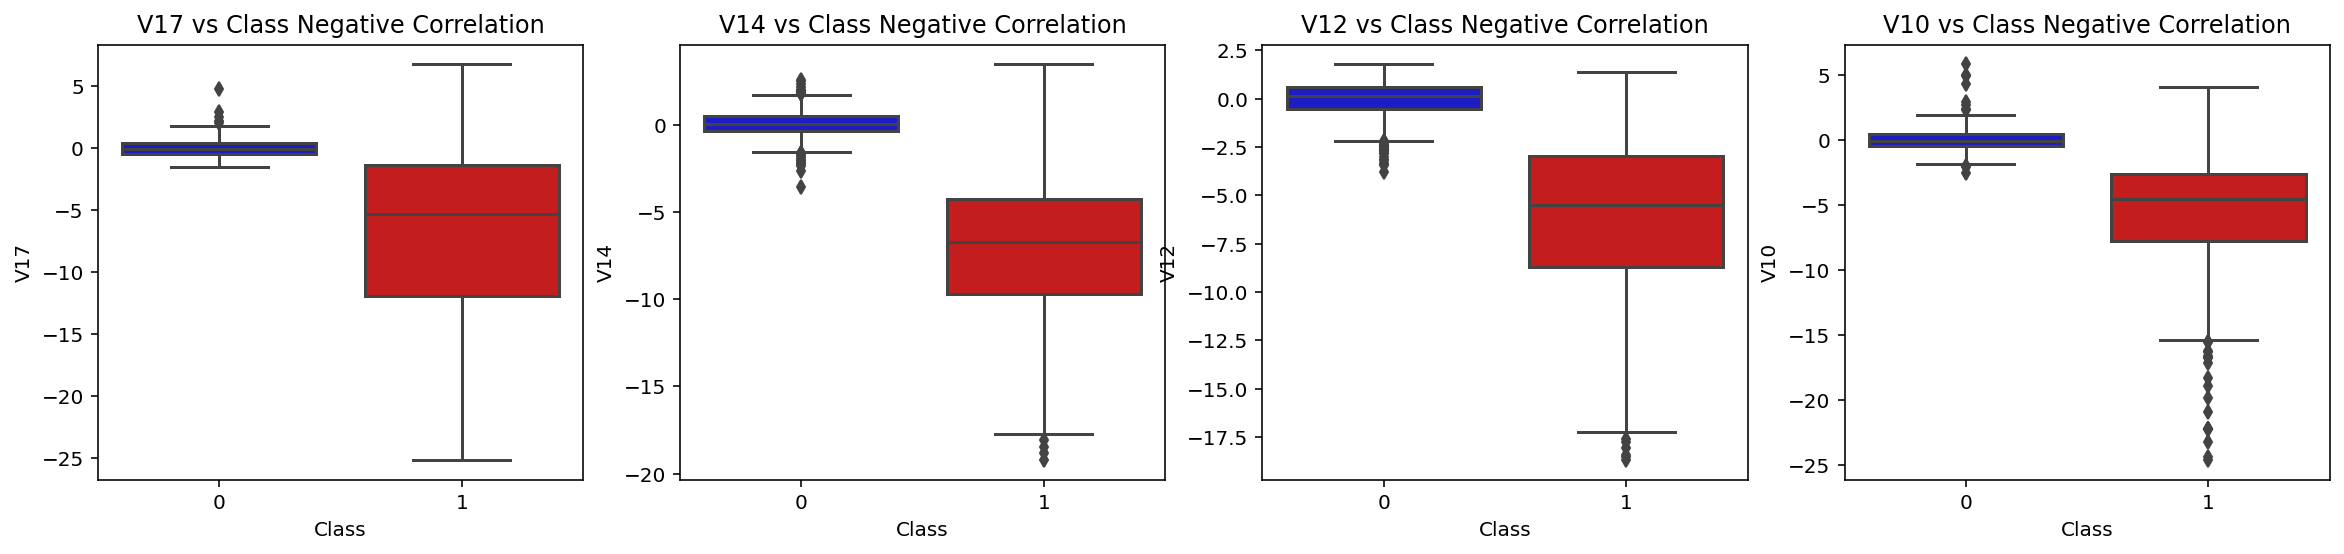

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# ВАШ КОД ЗДЕСЬ
axes[0].set_title('V17 vs Class Negative Correlation')

# ВАШ КОД ЗДЕСЬ
axes[1].set_title('V14 vs Class Negative Correlation')


# ВАШ КОД ЗДЕСЬ
axes[2].set_title('V12 vs Class Negative Correlation')


# ВАШ КОД ЗДЕСЬ
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

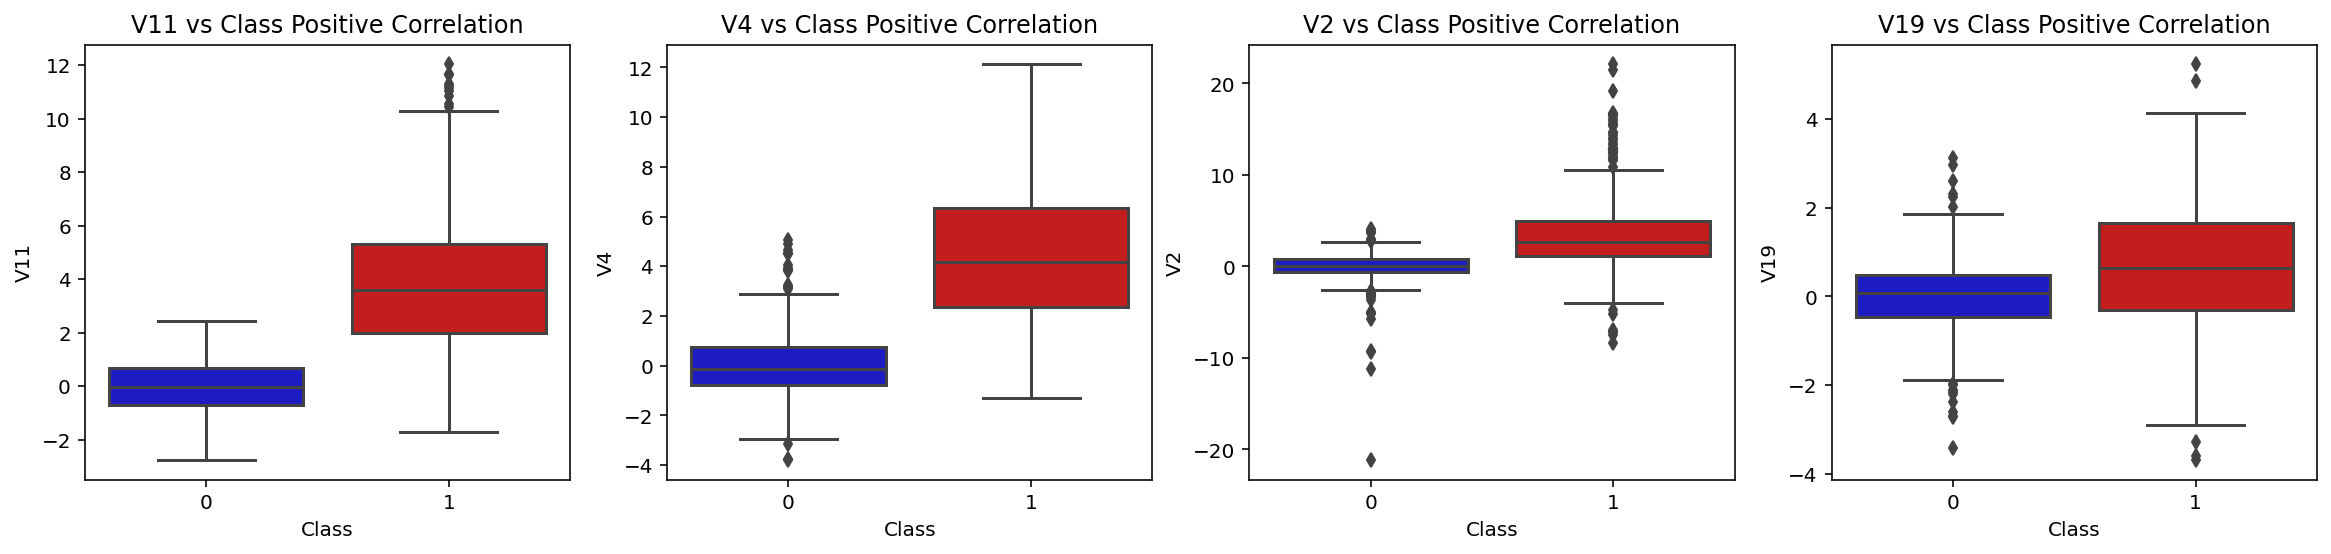

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# ВАШ КОД ЗДЕСЬ
axes[0].set_title('V11 vs Class Positive Correlation')

# ВАШ КОД ЗДЕСЬ
axes[1].set_title('V4 vs Class Positive Correlation')


# ВАШ КОД ЗДЕСЬ
axes[2].set_title('V2 vs Class Positive Correlation')


# ВАШ КОД ЗДЕСЬ
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

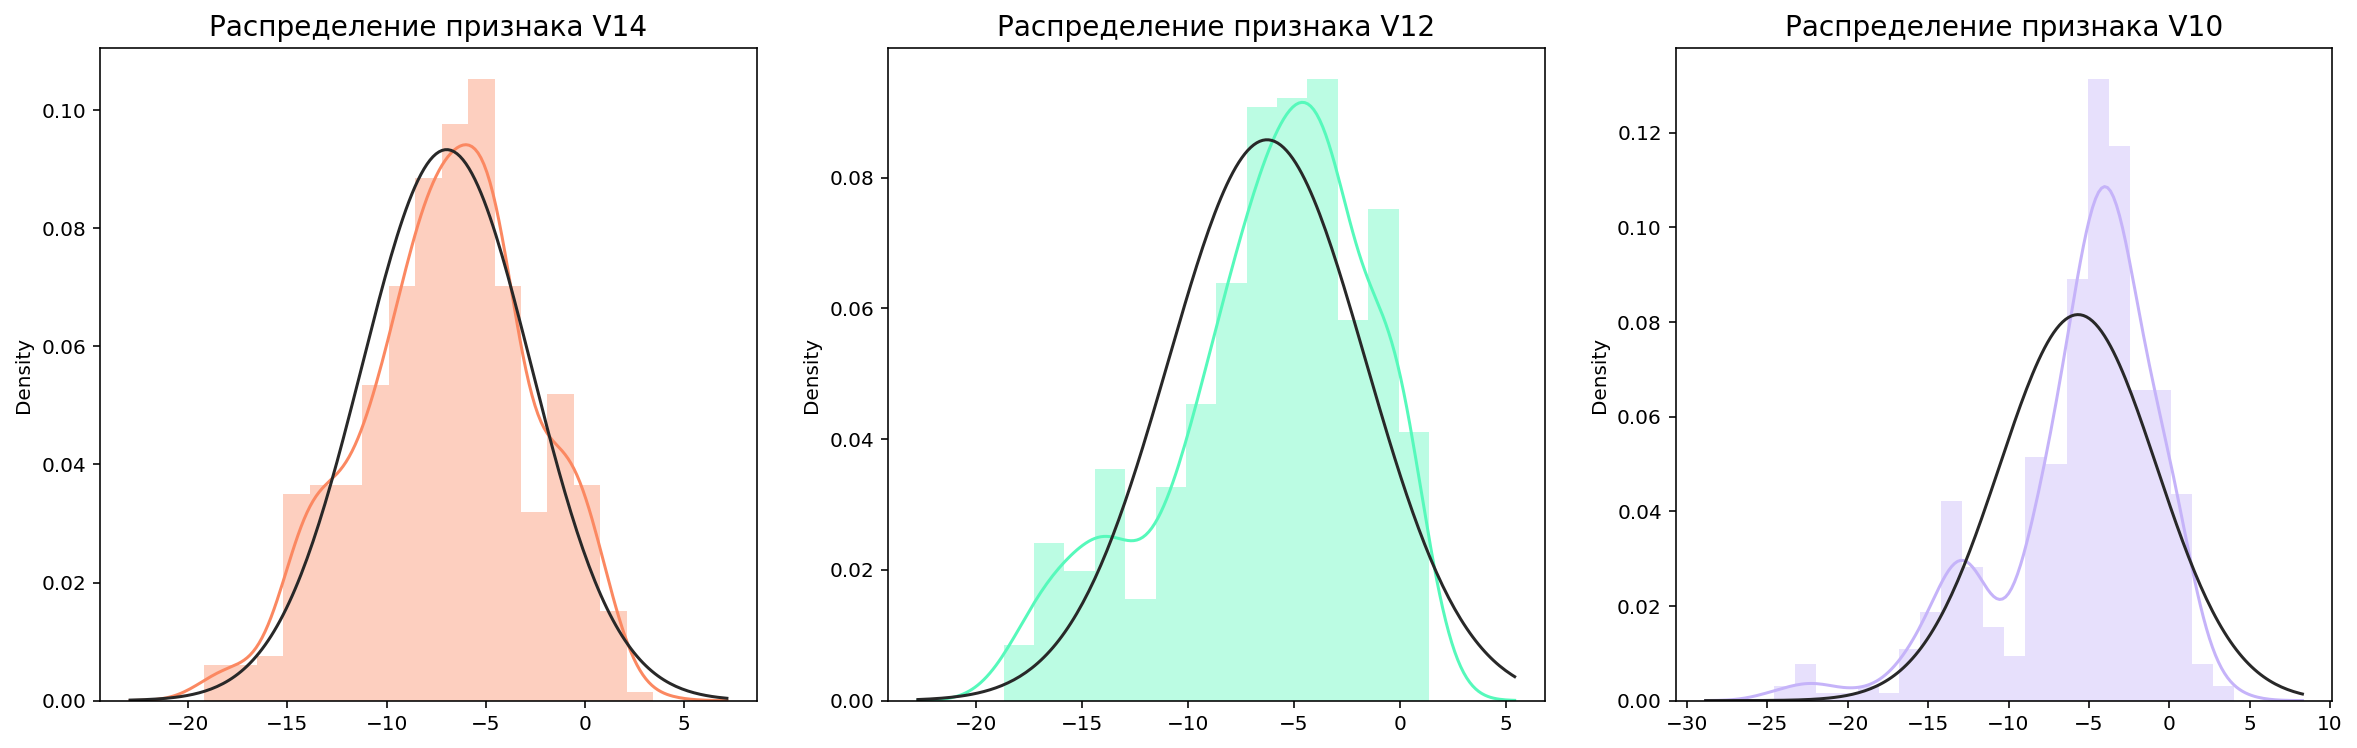

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
# ВАШ КОД ЗДЕСЬ
ax1.set_title('Распределение признака V14', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
# ВАШ КОД ЗДЕСЬ
ax2.set_title('Распределение признака V12', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
# ВАШ КОД ЗДЕСЬ
ax3.set_title('Распределение признака V10', fontsize=14)

plt.show()

In [ ]:
# Удаление выбросов из признака V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Порог: {}'.format(v14_cut_off))
print('V14 нижняя граница: {}'.format(v14_lower))
print('V14 верхняя граница: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Количество выбросов: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# Удаление выбросов из признака V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Порог: {}'.format(v12_cut_off))
print('V12 нижняя граница: {}'.format(v12_lower))
print('V12 верхняя граница: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Количество выбросов: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('----' * 44)


# Удаление выбросов из признака V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Порог: {}'.format(v10_cut_off))
print('V10 нижняя граница: {}'.format(v10_lower))
print('V10 верхняя граница: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Количество выбросов: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)

Квартиль 25: -9.692722964972386 | Квартиль 75: -4.282820849486865
iqr: 5.409902115485521
Порог: 8.114853173228282
V14 нижняя граница: -17.807576138200666
V14 верхняя граница: 3.8320323237414167
Количество выбросов: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -8.67303320439115 | Квартиль 75: -2.893030568676315
iqr: 5.780002635714835
Порог: 8.670003953572252
V12 нижняя граница: -17.3430371579634
V12 верхняя граница: 5.776973384895937
Количество выбросов: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: -7.466658535821847 | Квартиль 75: -2.5118611381562523
iqr: 4.954797397665595
Порог: 7.432196096498393
V10 нижняя граница: -14.89885463232024
V10 верхняя граница: 4.92033495834214
Количество выбросов: 27


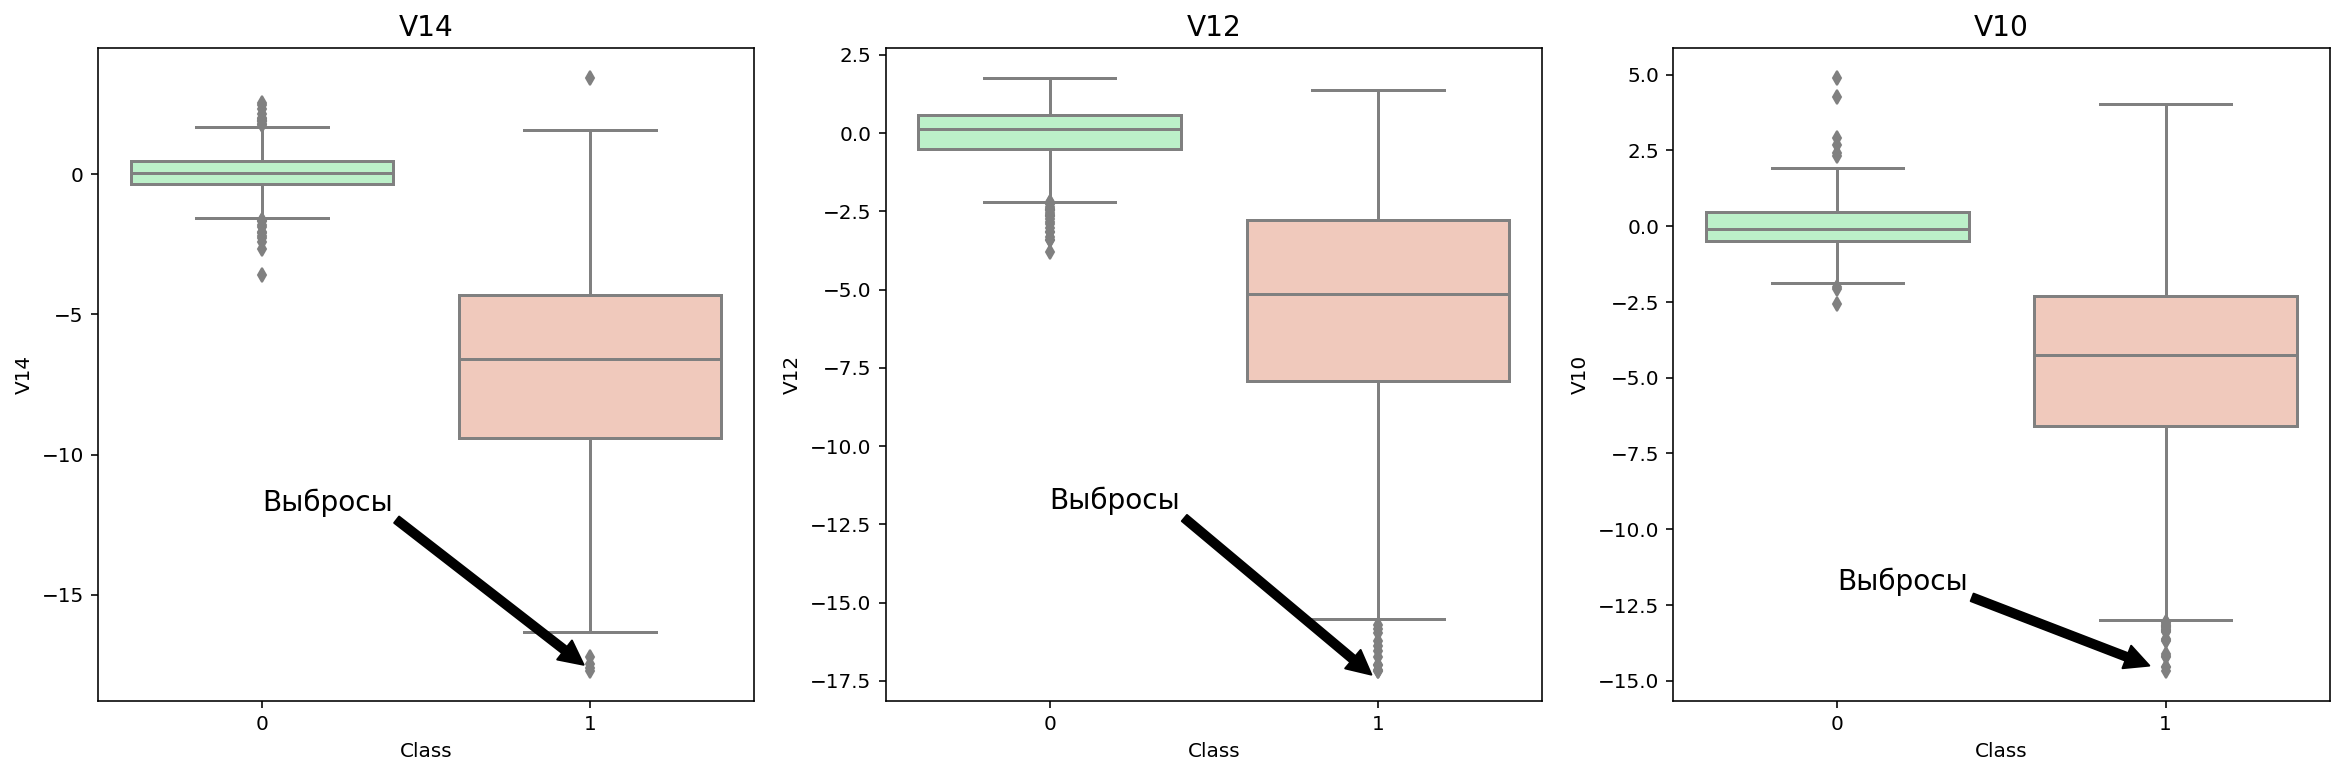

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplot для признака V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14", fontsize=14)
ax1.annotate('Выбросы', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Boxplot для признака V12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12", fontsize=14)
ax2.annotate('Выбросы', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Boxplot для признака V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10", fontsize=14)
ax3.annotate('Выбросы', xy=(0.95, -14.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.show()

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
# ВАШ КОД ЗДЕСЬ
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
# ВАШ КОД ЗДЕСЬ
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
# ВАШ КОД ЗДЕСЬ
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 1.1e+01 сек
PCA заняло 0.014 сек
Truncated SVD заняло 0.0096 сек


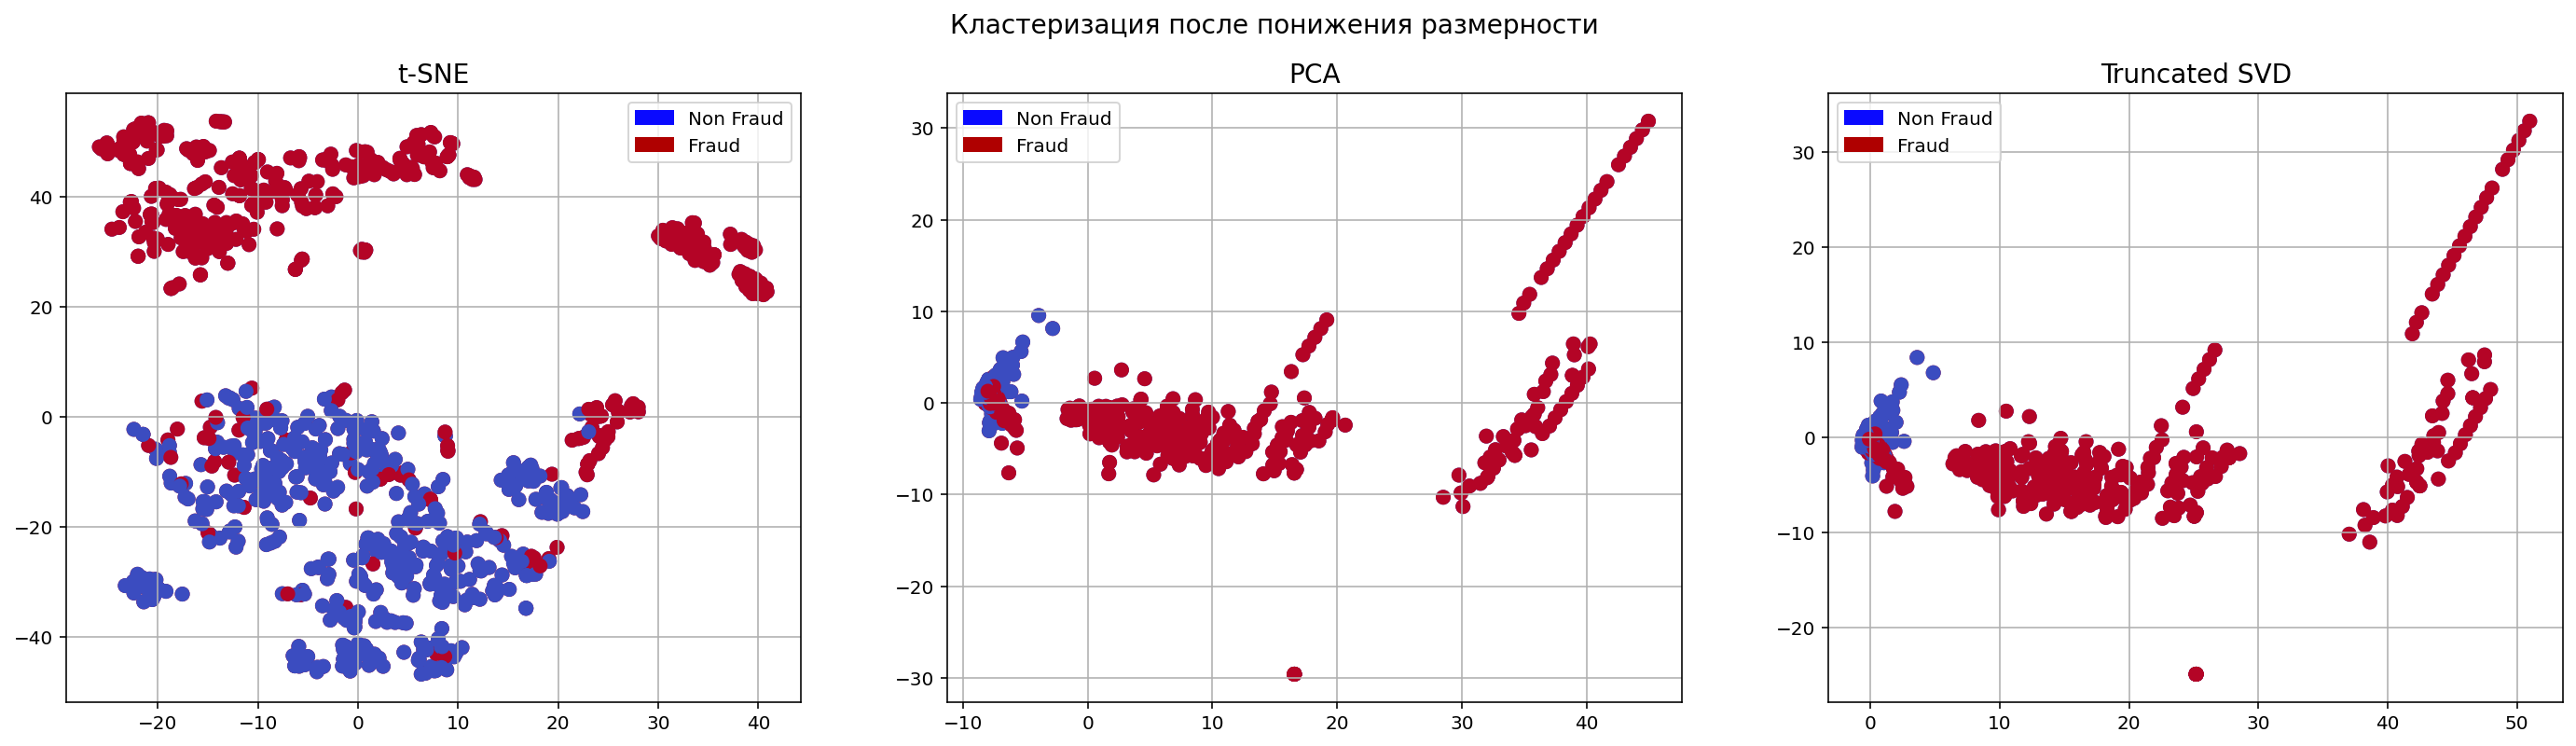

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h3> Выводы: </h3>
<ul> 
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Модели Scikit-learn 

В этом разделе мы будем строить различные  классификаторы библиотеки scikit-learn и сравнивать их метрики качества.


<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [ ]:
X_train, X_test, y_train, y_test = # ВАШ КОД ЗДЕСЬ

X_train['scaled_amount'] = # ВАШ КОД ЗДЕСЬ
X_test['scaled_amount'] = # ВАШ КОД ЗДЕСЬ

X_train['scaled_time'] = # ВАШ КОД ЗДЕСЬ
X_test['scaled_time'] = # ВАШ КОД ЗДЕСЬ

X_train.drop(['Time','Amount'], axis=1, inplace=True)
X_test.drop(['Time','Amount'], axis=1, inplace=True)

In [ ]:
# Переводим данные в массив для подачи в классификатор
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Выберем несколько простых моделей из библиотеки sklearn 

classifiers = {
    "LogisiticRegression": # ВАШ КОД ЗДЕСЬ, # Логистическая регрессия
    "KNearest": # ВАШ КОД ЗДЕСЬ, # Метод ближайших соседей
    "Support Vector Classifier": # ВАШ КОД ЗДЕСЬ, # Метод опорных векторов
    "DecisionTreeClassifier": # ВАШ КОД ЗДЕСЬ # Решающее дерево
}

Для борьбы с переобучением будем использовать кросс-валидацию.

<img src="https://scikit-learn.ru/wp-content/uploads/2021/10/image-161.png" width=800>

Разобьем обучающую выборку на 5 фолдов и обучим наши модели.

In [ ]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Модель ", classifier.__class__.__name__, "получила на обучающей выборке", round(training_score.mean(), 2) * 100, "% accuracy score")

Модель  LogisticRegression получила на обучающей выборке 94.0 % accuracy score
Модель  KNeighborsClassifier получила на обучающей выборке 93.0 % accuracy score
Модель  SVC получила на обучающей выборке 93.0 % accuracy score
Модель  DecisionTreeClassifier получила на обучающей выборке 91.0 % accuracy score


Для улучшения качества моделей переберем по сетке различные гиперпараматеры методом GridSearchCV.

<img src="https://cdn-images-1.medium.com/max/2000/1*E3FOlkD7LyeTbKMoTDnwFQ.png" width=800>

In [ ]:
# Используем поиск по сетке для подбора гиперпараметров
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# Выбираем лучшую модель
log_reg = # ВАШ КОД ЗДЕСЬ

# Метод ближайших соседей
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = # ВАШ КОД ЗДЕСЬ

# Метод опорных векторов
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

svc = # ВАШ КОД ЗДЕСЬ

# Решающее дерево
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = # ВАШ КОД ЗДЕСЬ

In [ ]:
# Проверим, как поменялись метрики

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.18%
Knears Neighbors Cross Validation Score 94.44%
Support Vector Classifier Cross Validation Score 93.52%
DecisionTree Classifier Cross Validation Score 92.06%


Видим явное улучшение!

Давайте теперь попробуем более умные способы undersampling. Например, с помощью NearMiss, который оценивает среднее расстояние между классами. Поможет нам в этом специальная библиотека для работы с несбалансированными даннными imblearn.

In [ ]:
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

from sklearn.metrics import (precision_score, roc_auc_score, recall_score, f1_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve, accuracy_score)

undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

undersample_Xtrain, undersample_Xtest, undersample_ytrain, undersample_ytest = # ВАШ КОД ЗДЕСЬ

undersample_Xtrain['scaled_amount'] = # ВАШ КОД ЗДЕСЬ
undersample_Xtest['scaled_amount'] = # ВАШ КОД ЗДЕСЬ

undersample_Xtrain['scaled_time'] = # ВАШ КОД ЗДЕСЬ
undersample_Xtest['scaled_time'] = # ВАШ КОД ЗДЕСЬ

undersample_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
undersample_Xtest.drop(['Time','Amount'], axis=1, inplace=True)
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Метод NearMiss
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss распределение классов: {}'.format(Counter(y_nearmiss)))
# Использовать сэмплирование будем во время кросс-валидации

for train, test in skf.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = # ВАШ КОД ЗДЕСЬ
    undersample_model = # ВАШ КОД ЗДЕСЬ
    undersample_prediction = # ВАШ КОД ЗДЕСЬ
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

NearMiss распределение классов: Counter({0: 492, 1: 492})


Построим кривую обучение каждой из модели. Данная кривая показывает различие между метриками во время обычного обучения и во время кросс-валидации.

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)

    # Первая модель
    train_sizes, train_scores, test_scores = # ВАШ КОД ЗДЕСЬ
    train_scores_mean = # ВАШ КОД ЗДЕСЬ
    train_scores_std = # ВАШ КОД ЗДЕСЬ
    test_scores_mean = # ВАШ КОД ЗДЕСЬ
    test_scores_std = # ВАШ КОД ЗДЕСЬ
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Размер выборки')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Вторая модель

    
    # Третья модель
    
    
    # Четвертая модель
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

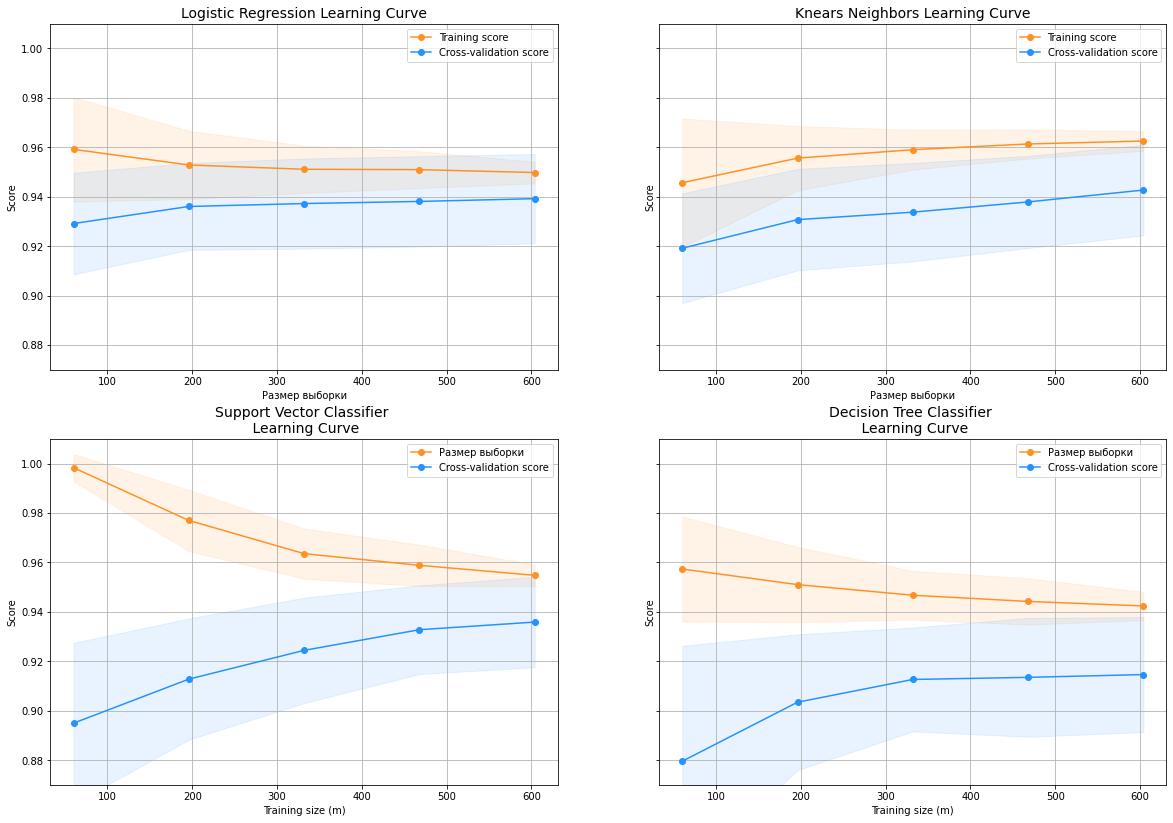

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

## Кривые обучения:
<ul>
<li>Чем больше разрыв между результатами обучения и результатами кросс-валидации, тем больше вероятность того, что модель переобучилась (большой разброс).</li>
<li> Если результаты низкие как на обучающем, так и на кросс-валидационном наборе, это указывает на то, что наша модель недообучилась (большое смещение).</li>
<li>Логистическая регрессия показала себя лучше остальных.</li>
</ul>

In [ ]:
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9779896669046919
KNears Neighbors:  0.9331429131487937
Support Vector Classifier:  0.9725430895674941
Decision Tree Classifier:  0.9197504935523164


Построим roc-кривую и посчитаем площадь под ней.

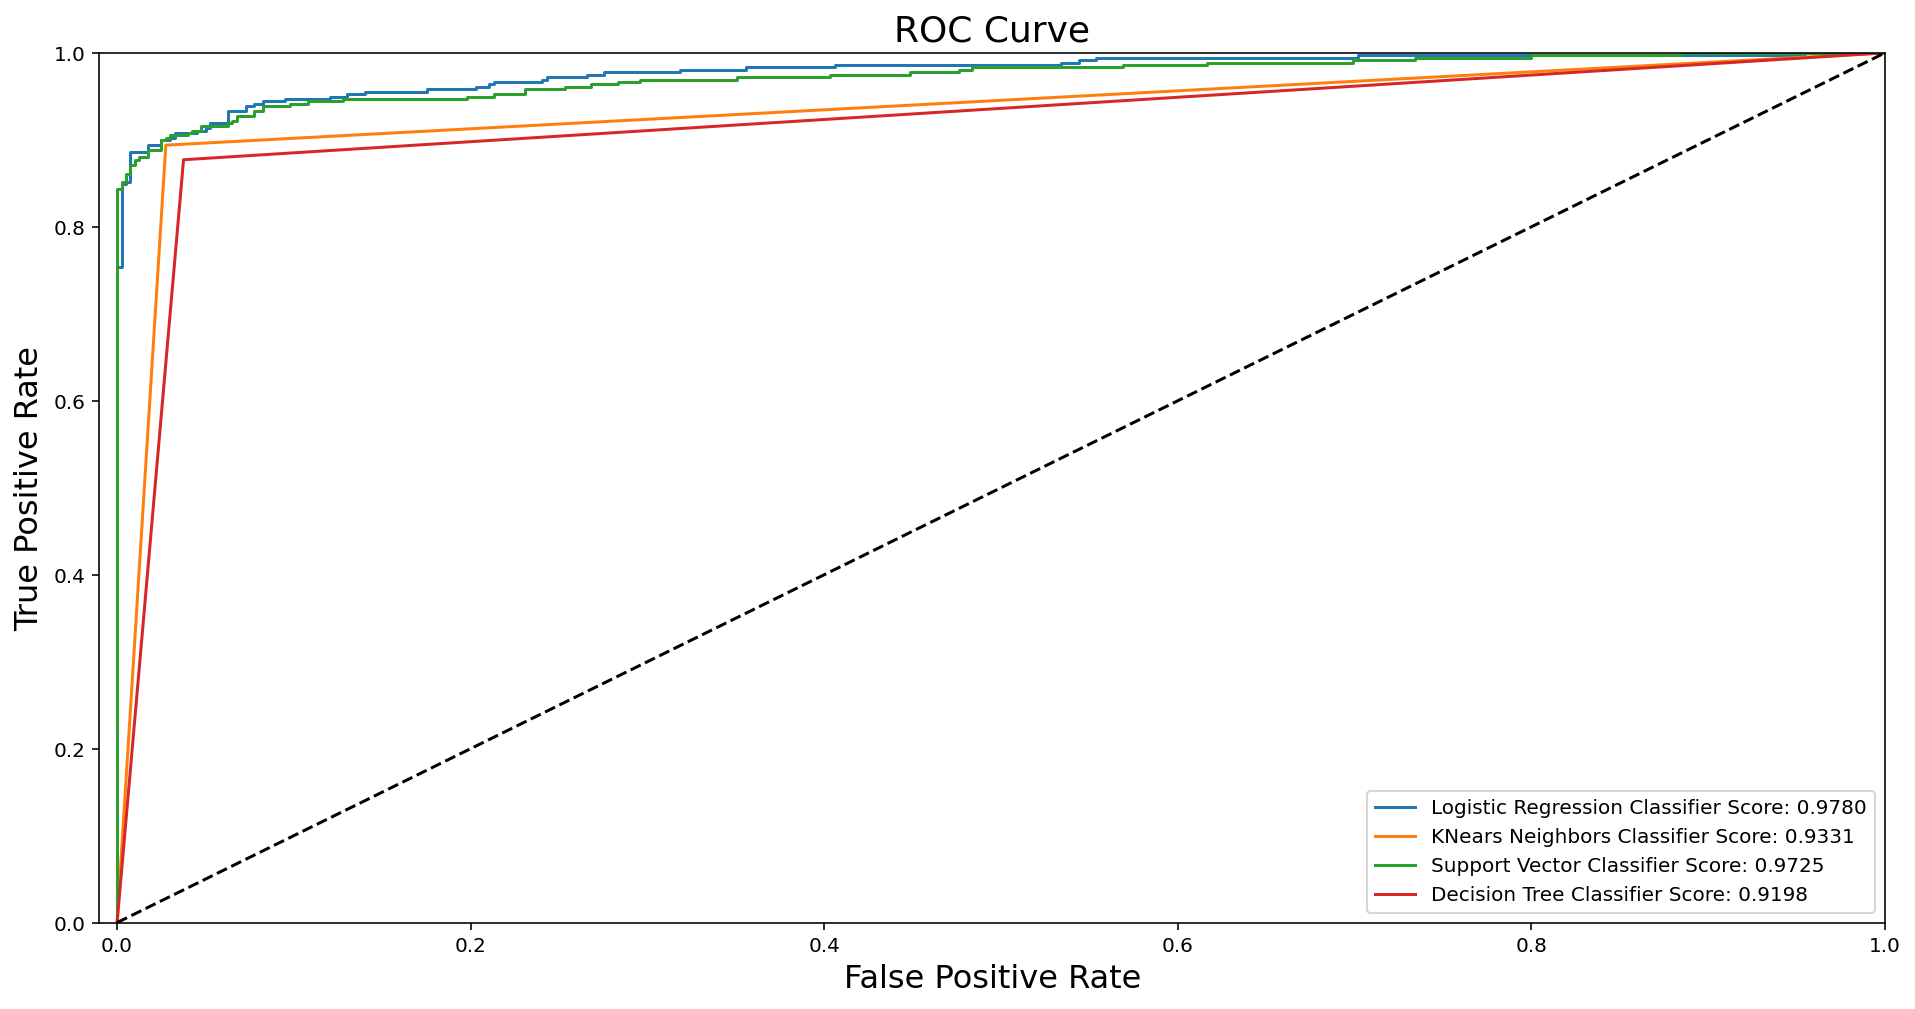

In [ ]:
log_fpr, log_tpr, log_thresold = # ВАШ КОД ЗДЕСЬ
knear_fpr, knear_tpr, knear_threshold = # ВАШ КОД ЗДЕСЬ
svc_fpr, svc_tpr, svc_threshold = # ВАШ КОД ЗДЕСЬ
tree_fpr, tree_tpr, tree_threshold = # ВАШ КОД ЗДЕСЬ


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

### SMOTE метод (Over-Sampling):

<b>SMOTE</b> означает Synthetic Minority Over-sampling Technique.  В отличие от Random Under-Sampling, SMOTE создает новые синтетические точки для того, чтобы создать баланс классов. Это еще одна альтернатива для решения проблемы дисбаланса классов. <br><br>


<b> Принцип работы SMOTE: </b>
<ul>
<li><b>Генерация синтетических точек: </b> SMOTE выбирает расстояние между ближайшими соседями меньшего класса и между ними создает синтетические точки. </li>
<li> <b>Преимущество:  </b> Сохраняется больше информации, поскольку нам не пришлось удалять данные, в отличие от under-sampling.</li>
</ul>

### Правильное использование SMOTE
Если мы создадим синтетические точки перед кросс-валидацией, мы окажем определенное влияние на тестовое выборку. Но тестовая выборка не должна быть тронута! По этой причине мы должны создавать синтетические точки данных во время кросс-валидации, а не до нее.

Попробуем в качестве алгоритм подбора гиперпараметров случайный поиск. Он работает быстрее, чем поиск по сетке. 

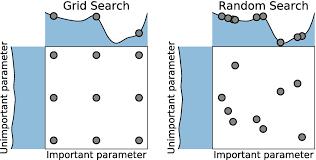

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

print('Размер обучающей выборки (train): {} | Размер целевой переменной (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Размер тестовой выборки (test): {} | Размер целевой переменной (test): {}'.format(len(original_Xtest), len(original_ytest)))

# Списки с значениями метрик
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Реализация SMOTE подхода 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in skf.split(original_Xtrain, original_ytrain):
    pipeline = # ВАШ КОД ЗДЕСЬ # Добавляем SMOTE во время кросс-валидации
    model = # ВАШ КОД ЗДЕСЬ
    best_est = # ВАШ КОД ЗДЕСЬ
    prediction = # ВАШ КОД ЗДЕСЬ
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Размер обучающей выборки (train): 227845 | Размер целевой переменной (train): 227845
Размер тестовой выборки (test): 56962 | Размер целевой переменной (test): 56962
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9748644912111303
precision: 0.05941489431686377
recall: 0.9086335605322947
f1: 0.11149204047275804
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
labels = ['Non Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

   Non Fraud       1.00      0.97      0.99     56864
       Fraud       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962



In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Применим SMOTE после кросс-валидации
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
# Обучим логистическую регрессию
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Время обучения: {} сек".format(t1 - t0))

Время обучения: 6.022240400314331 сек


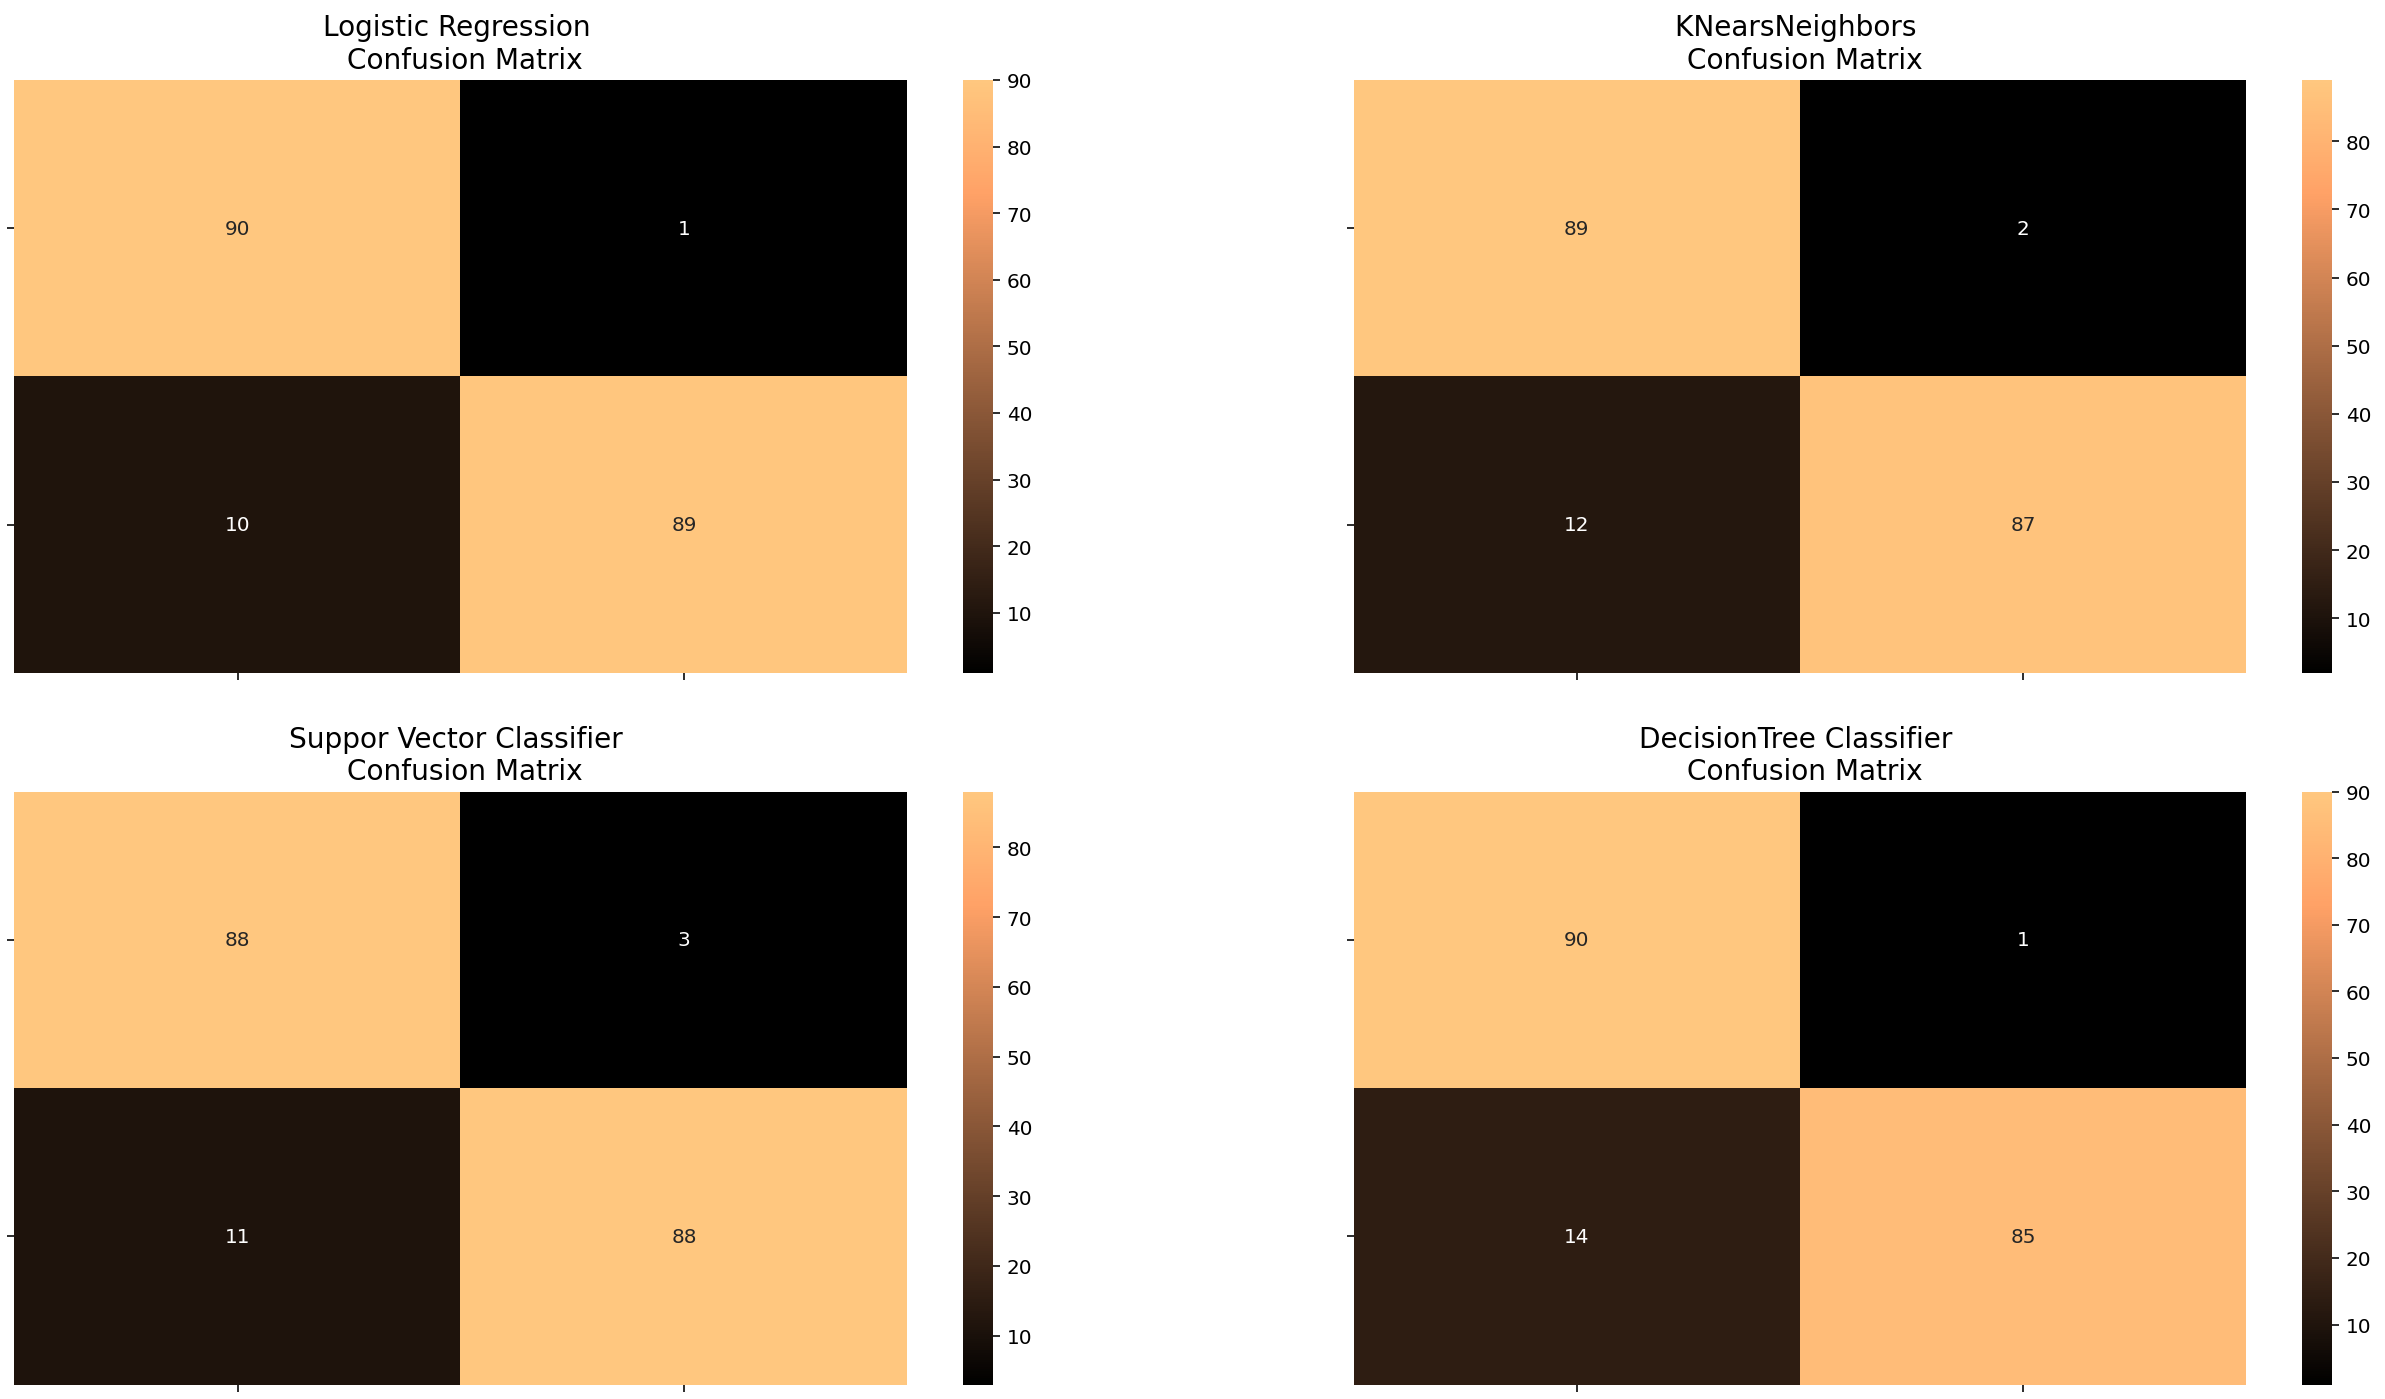

In [ ]:
y_pred_log_reg = log_reg_sm.predict(X_test)

# Другие модели
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

# Построим матрицы ошибок
# ВАШ КОД ЗДЕСЬ
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# ВАШ КОД ЗДЕСЬ
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# ВАШ КОД ЗДЕСЬ
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# ВАШ КОД ЗДЕСЬ
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

Выведем основные метрики моделей. 

Давайте вспомним основные метрики качества классификации на примере нашей задачи:

* **Confusion matrix** : так же известна как матрица ошибок, состоит из 4 частей:

    * true positive (TP) : транзакция была мошеннической и модель предсказала ее как мошенническую
    * true negative (TN) : транзакция была нормальной и модель определила ее как нормальную
    * false positive (FP) : транзакция была нормальная, но модель среагировала на нее как на мошенническую
    * false negative (FN) : транзакция была мошенническая, но модель ее пропустила и посчитала нормальной


* **Метрики** :

    * Accuracy : (TP +TN) / (TP + TN + FP +FN)
    * Precision : TP / (TP + FP) (подходит при дисбалансе)
    * Recall : TP / (TP + FN) (подходит при дисбалансе)
    * F1 score : 2 x ((Precision x Recall) / (Precision + Recall)) (подходит при дисбалансе)

* **Roc-кривая** : ROC-кривая строится путем отрисовки графика зависимости частоты истинных положительных результатов (TPR) от частоты ложных положительных результатов (FPR) при различных пороговых значениях.

In [ ]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
# ВАШ КОД ЗДЕСЬ

print('KNears Neighbors:')
# ВАШ КОД ЗДЕСЬ

print('Support Vector Classifier:')
# ВАШ КОД ЗДЕСЬ

print('Support Vector Classifier:')
# ВАШ КОД ЗДЕСЬ

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        91
           1       0.99      0.90      0.94        99

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.95      0.94      0.94       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        91
           1       0.98      0.88      0.93        99

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted avg       0.93      0.93      0.93       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        91
           1       0.97      0.89      0.93        99

    accuracy                           0.93       190
   macro avg       0.93      0.93      0.93       190
weighted

Поскольку мы выбрали логистическую регрессию в качестве основной модели, давайте сравним ее качество в случае подхода under-sampling и в случае over-sampling.

In [ ]:
# Логистическая регрессия с under-sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Логистическая регрессия с over-sampling
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Метод': ['Random Under-Sampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Метод,Score
0,Random Under-Sampling,0.942105
1,Oversampling (SMOTE),0.971648


Итак, в данной задаче более оптимальным подходом оказался over-samplimg методом SMOTE. 

## Градиентный бустинг LightGBM

Мы подробно рассмотрели методы удаления и добавления данных при сильном дисбалансе. Однако эти методы все же содержат в себе изъян: мы обучаем модель на ненастоящих данных, внося искажения в их истинное распределение. Но мы использовали довольно простые алгоритмы и боялись переобучения. А что если мы все же попробуем обучиться на первоначальном наборе? Возьмем для этого более продвинутый алгоритм - градиентный бустинг от LightGBM.

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = # ВАШ КОД ЗДЕСЬ

In [ ]:
# Функция детальной отрисовки всех метрик и важности признаков модели
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff


def model_performance(model) : 
    # Матрица ошибок
    conf_matrix = # ВАШ КОД ЗДЕСЬ
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    # Метрики
    tp = # ВАШ КОД ЗДЕСЬ
    fn = # ВАШ КОД ЗДЕСЬ
    fp = # ВАШ КОД ЗДЕСЬ
    tn = # ВАШ КОД ЗДЕСЬ
    Accuracy  =  # ВАШ КОД ЗДЕСЬ
    Precision =  # ВАШ КОД ЗДЕСЬ
    Recall    =  # ВАШ КОД ЗДЕСЬ
    F1_score  =  # ВАШ КОД ЗДЕСЬ

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    # Roc-кривая
    model_roc_auc = # ВАШ КОД ЗДЕСЬ
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall кривая
    precision, recall, thresholds = # ВАШ КОД ЗДЕСЬ
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    # Значимость признаков модели
    coefficients  = pd.DataFrame(eval(model).feature_importances_)
    column_data   = pd.DataFrame(list(df))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace6 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    
    # Кривая кумулятивного выигрыша (оценивает эффективность модели и сравнивает результаты со случайной выборкой)
    pos = pd.get_dummies(y_test).values
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    # Кумулятивная сумма
    cpos = np.cumsum(sort_pos) 
    # Recall
    recall = cpos/npos 
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    size = size / n 
    model = model
    trace7 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('gold'),width = 2), fill='tozeroy') 
    
    # Отрисовываем графики
    fig = tls.make_subplots(rows=4, cols=2, print_grid=False, 
                          specs=[[{}, {}], 
                                 [{}, {}],
                                 [{'colspan': 2}, None],
                                 [{'colspan': 2}, None]],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        'Cumulative gains curve',
                                        'Feature importance',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    fig.append_trace(trace6,4,1)
    fig.append_trace(trace7,3,1)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    fig.show(renderer="colab") # для отрисовки в colab

**LightGBM** - это реализация градиентного бустинга, использующая древовидные алгоритмы обучения. Она разработана как распределенная и эффективная система со следующими преимуществами:

* Высокая скорость обучения и эффективность
* Низкое потребеление памяти
* Высокие значения метрик
* Поддерживает распареллеливание (в том числе на GPU)
* Возможность работы с большими объемами данных

In [ ]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(n_estimators=100, random_state = 42)

lgbm_clf.fit(X_train, y_train)
y_pred = # ВАШ КОД ЗДЕСЬ
y_score = # ВАШ КОД ЗДЕСЬ

In [ ]:
model_performance('lgbm_clf')

Видим, что метрики получились не очень хорошие. Причина в том, что совсем не подбирали гиперпараметров. Давайте исправимся!

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# неизменные параметры
fit_params = # ВАШ КОД ЗДЕСЬ

# подбор гиперпараметров
param_test = # ВАШ КОД ЗДЕСЬ

# Количество итераций поиска
n_iter = 2

lgbm_clf = lgbm.LGBMClassifier(random_state=42, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='f1',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Лучший результат: {} с параметрами: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

clf_sw = lgbm.LGBMClassifier(**lgbm_clf.get_params())
clf_sw.set_params(**opt_parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Лучший результат: 0.7996605169467343 с параметрами: {'colsample_bytree': 0.6002251666834131, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 230, 'min_child_weight': 10.0, 'n_estimators': 500, 'num_leaves': 7, 'reg_alpha': 50, 'reg_lambda': 5, 'subsample': 0.9508421672126002} 


LGBMClassifier(colsample_bytree=0.6002251666834131, learning_rate=0.2,
               max_depth=7, metric='None', min_child_samples=230,
               min_child_weight=10.0, n_estimators=500, n_jobs=4, num_leaves=7,
               random_state=42, reg_alpha=50, reg_lambda=5,
               subsample=0.9508421672126002)

In [ ]:
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.6002251666834131, importance_type='split',
        learning_rate=0.2, max_depth=7, metric='None',
        min_child_samples=230, min_child_weight=0.01, min_split_gain=0.0,
        n_estimators=500, n_jobs=4, num_leaves=7, objective=None,
        random_state=42, reg_alpha=50, reg_lambda=5, silent=True,
        subsample=0.9508421672126002)

lgbm_clf.fit(X_train, y_train)
y_pred = # ВАШ КОД ЗДЕСЬ
y_score = # ВАШ КОД ЗДЕСЬ

In [ ]:
model_performance('lgbm_clf')

Отлично! Результаты очень обнадеживающие. Мы превзошли результаты логистической регрессии. Но самое важное другое: мы никак не изменяли данные и  учились честно, поэтому эта модель предпочтительнее для использования. 

## Deep learning

Итак, мы добрались и до глубокого обучения. Все указанные выше классические методы были довольно требовательны: нам приходилось усердно работать с данными и параметрами самих моделей, чтобы добиться результата. Есть ли альтернатива? 

### Автокодировщик

<img src="https://machinelearningmastery.ru/img/0-43983-564101.png" width=800>

Как видно из рисунка, автокодировщик имеет ту же архитектуру, что и обычный MLP (многослойный перцептрон), за исключением требования, чтобы количество входных нейронов было равно количеству нейронов в выходном слое. Автокодировщик во время обучения выучивает внутренние представления данных так, чтобы по входу можно было реконструировать выход. Таким образом, это означает, что автокодировщик не может просто копировать ввод в вывод, он вынужден изучать наиболее важные признаки ввода и отбрасывать остальные.

Как мы можем использовать автокодировщик для обнаружения мошеннических транзакций? Автокодировщиком мы пытаемся оптимизировать модель (то есть параметры модели), чтобы минимизировать ошибку реконструкции. Теперь предположим, что мы подаем цифру 5 и на выходе получаем восстановленную цифру 5 с минимальной ошибкой восстановления. Теперь попробуем скормить другую цифру, которая пытается имитировать 5, когда мы получим на выходах ее восстановленную версию, она будет с большой ошибкой реконструкции. Это логика использования автокодировщика для обнаружения мошенничества. На вход подаем вектор из признаков (30 признаков).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

# создаем модель
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = # ВАШ КОД ЗДЕСЬ # энкодер
            # ВАШ КОД ЗДЕСЬ, # линейный слой
            # ВАШ КОД ЗДЕСЬ, # активация тангенс
            # ВАШ КОД ЗДЕСЬ,
            # ВАШ КОД ЗДЕСЬ, # активация LeakyReLU
            )
        
        self.decoder = # ВАШ КОД ЗДЕСЬ # декодер
        )

    # прямой проход
    def forward(self, x):
        x = # ВАШ КОД ЗДЕСЬ
        x = # ВАШ КОД ЗДЕСЬ
        return x

In [ ]:
device = # ВАШ КОД ЗДЕСЬ # загружаем на GPU

In [ ]:
model = Autoencoder()
model = model.to(device)

In [ ]:
num_epochs = 10 # количество эпох
batch_size = 32 # размер батча
learning_rate = 1e-3 # скорость обучения

In [ ]:
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

In [ ]:
# загрузка данных

train_loader = # ВАШ КОД ЗДЕСЬ
test_loader =# ВАШ КОД ЗДЕСЬ

In [ ]:
criterion = # ВАШ КОД ЗДЕСЬ # функция потерь
optimizer = # ВАШ КОД ЗДЕСЬ # оптимизатор

In [ ]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [ ]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # загружаем на устройство
        data = # ВАШ КОД ЗДЕСЬ
        data = data.to(torch.float32)
        # ===================forward=====================
        output = model(data)
        loss = # ВАШ КОД ЗДЕСЬ
        h = np.append(h, loss.item())
        
        # ===================backward====================
       # ВАШ КОД ЗДЕСЬ
        # ВАШ КОД ЗДЕСЬ
        # ВАШ КОД ЗДЕСЬ
    # ===================логгирование========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    
# сохраняем веса модели
# ВАШ КОД ЗДЕСЬ

epoch [1/10], loss:1.0201
epoch [2/10], loss:0.8755
epoch [3/10], loss:0.8482
epoch [4/10], loss:0.8335
epoch [5/10], loss:0.8241
epoch [6/10], loss:0.8164
epoch [7/10], loss:0.8103
epoch [8/10], loss:0.8041
epoch [9/10], loss:0.8010
epoch [10/10], loss:0.7987


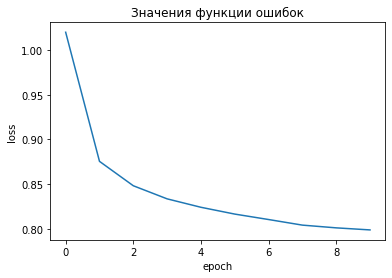

In [ ]:
plt.plot(history['train_loss'])
plt.title('Значения функции ошибок')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred_losses = {'pred_loss' : []}
model.eval() # режим инференса
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        data = data.to(torch.float32)
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

В зависимости от порога, мы будем получать разные значения метрик.

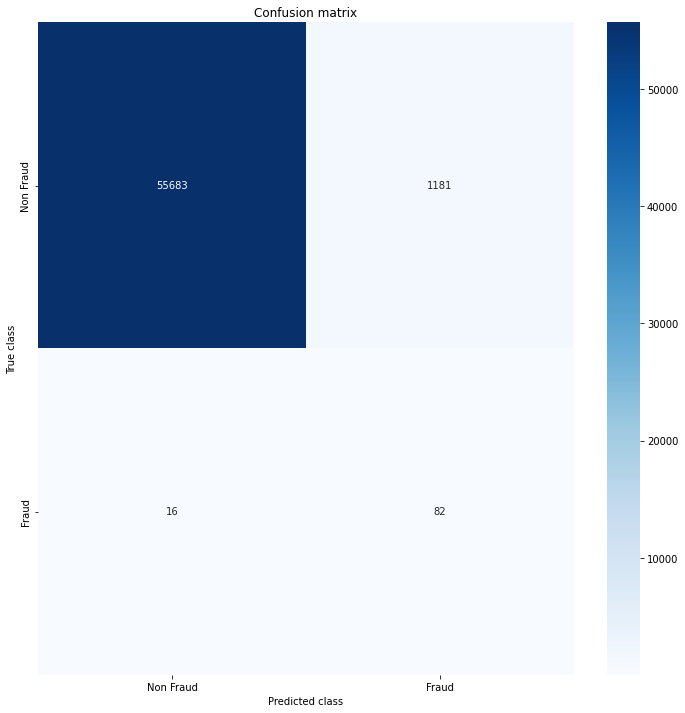

In [ ]:
threshold = 3

LABELS = ["Non Fraud", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
# строим матрицу ошибок
# ВАШ КОД ЗДЕСЬ
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'))
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Итак, мы видим, что автокодировщик прекрасно справился с задачей, несмотря на сильный дисбаланс в данных!